In [2]:
#parte 1: librerias

In [3]:
import astropy
import numpy as np
import scipy
import numpy
import pyspeckit
import zipfile
import os
import re
import matplotlib.pyplot as plt
from astropy.table import QTable,Table,Column
from astropy.io import ascii
from sklearn.metrics import auc
from openpyxl import load_workbook
import xlrd


In [4]:
#parte 2: funciones

In [5]:
def Filterdat(lista): #filtrar datos de directorios por ".dat"
    return [name for name in lista if re.search(r'dat', name)]

def colxfil(mat): #en una tabla, o matriz, cambiar filas por columnas
    num=[i for i in range(len(mat[0]))]
    aux=[]
    mat2=[]
    for pos in num:
        aux=[]
        for lista in mat:
            aux.append(lista[pos])
        
        mat2.append(aux)
    return mat2

#def norm(lista): #normalizacion de datos por preprocessing
#    return preprocessing.normalize(lista)

def norm(lista): #normalización de datos por maximos y minimos
    a=[]
    for f in lista:
        a.append((f-min(lista))/(max(lista)-min(lista)))
    return a

def unique(lista):
    uni=[]
    for l in lista:
        if l not in uni:
            uni.append(l)
    return uni

def recta2(punto1,punto2,evaluar): #crea valores entre 2 puntos en funcion de un conjunto externo
    x1=punto1[0]
    y1=punto1[1]
    x2=punto2[0]
    y2=punto2[1]
    if x2!=x1:
        m=(y2-y1)/(x2-x1)
    if x2==x1:
        pass
    c=y1-(m*x1)
    return (m*evaluar)+c 

def convol(espectra, filtro): #entrada de variables
    
    #parte 1: separar datos y limites
    espec=[]
    fl=[]
    espec_wl=[]
    fl_wl=[]
    coords1=[]
    coords2=[]
    for pair in espectra: #guardado de datos para crear tabala general en base a los "S" y "F"
        espec.append((float(pair[0]),float(pair[1]),'S'))
        coords1.append((float(pair[0]),float(pair[1])))
        espec_wl.append(float(pair[0]))
    for pair in filtro:
        fl.append((float(pair[0]),float(pair[1]),'F'))
        coords2.append((float(pair[0]),float(pair[1])))
        fl_wl.append(float(pair[0])) #limites 
    
    
    minimum=min(fl_wl) #limite minimo
    maximum=max(fl_wl) #limite maximo
    
    wl=(sorted(espec+fl)) #conjunto ordenado en funcion de la longitud de onda
    no_existe_en_spec=[value for value in fl_wl if  value not in espec_wl]
    no_existe_en_fil=[value for value in espec_wl if  value not in fl_wl]
    
    #parte 2: generar tabla final con datos
    final_table=Table() 
    final_table['Wavelength']=([w[0] for w in wl]) #tabla general
    final_table['Spectra']=[None for i in wl]
    final_table['Filter']=[None for i in wl]
    
    for wave,tri in zip(final_table['Wavelength'],wl):
        indice_wl=list(final_table['Wavelength']).index(wave) #fila
        if tri[2]=='S': #ordenar segun indice "S"pectra
            final_table['Spectra'][indice_wl]=tri[1]
        if tri[2]=='F': #ordenar segun indice "F"ilter
            final_table['Filter'][indice_wl]=tri[1]
    
    #parte 3: quitar vacios repetidos                                              
    general=[]
    vacios=[]
    for tri in final_table:
        general.append(tri)
        if tri['Spectra']==None and tri['Filter']==None:
            vacios.append(tri)
    for tri in vacios:
        general.remove(tri)
     
       
    #parte 4: tabla reducida
    tabla_redu=Table()
    WL=[]
    SP=[]                                              
    FL=[]
    for tri in general:
        WL.append(tri['Wavelength'])
        SP.append(tri['Spectra'])
        FL.append(tri['Filter'])
    
    tabla_redu['Wavelength']=WL
    tabla_redu['Spectra']=SP                                            
    tabla_redu['Filter']=FL 
    
    
    #parte 5: rellenar
    
    #spectra
    indices1=[coords1.index(value) for value in coords1]
    
    valores=[]
    lambda_A=[]
    for index in indices1[:len(indices1)-1]:
        puntos=[coords1[index],coords1[index+1]]
        
        for value in no_existe_en_spec:
            if value>puntos[0][0] and value<puntos[1][0]:
                aux=recta2(puntos[0],puntos[1],value)
                lambda_A.append(value)
                valores.append([value,aux])
    
    SP_ind=[list(tabla_redu['Wavelength']).index(value) for value in lambda_A]
    for pair,ind in zip(valores,SP_ind):
        if tabla_redu['Spectra'][ind]==None:
            tabla_redu['Spectra'][ind]=pair[1]
    
    
    
    
   #filtro
    indices2=[coords2.index(value) for value in coords2]
    
    valores=[]
    lambda_B=[]
    for index in indices2[:len(indices2)-1]:
        puntos=[coords2[index],coords2[index+1]]
        
        for value in no_existe_en_fil:
            if value>puntos[0][0] and value<puntos[1][0]:
                aux=recta2(puntos[0],puntos[1],value)
                lambda_B.append(value)
                valores.append([value,aux])
    
    FL_ind=[list(tabla_redu['Wavelength']).index(value) for value in lambda_B]
    for pair,ind in zip(valores,FL_ind):
        if tabla_redu['Filter'][ind]==None:
            tabla_redu['Filter'][ind]=pair[1]

    tabla_redu=tabla_redu[tabla_redu['Wavelength']>=minimum]
    tabla_redu=tabla_redu[tabla_redu['Wavelength']<=maximum]
    
    #parte 6: tabla de minimos
    espectro_final=[]
    for tri in tabla_redu:
        espectro_final.append(min([tri['Spectra'],tri['Filter']]))

    Out=Table()
    Out['Wavelength']=tabla_redu['Wavelength']
    Out['Spectra']=espectro_final

    return [Out,auc(Out['Wavelength'],Out['Spectra'])]

In [298]:
def test_convol(espectra, filtro): #entrada de variables
    
    #parte 1: separar datos y limites
    espec=[]
    fl=[]
    espec_wl=[]
    fl_wl=[]
    coords1=[]
    coords2=[]
    for pair in espectra: #guardado de datos para crear tabala general en base a los "S" y "F"
        espec.append((float(pair[0]),float(pair[1]),'S'))
        coords1.append((float(pair[0]),float(pair[1])))
        espec_wl.append(float(pair[0]))
    for pair in filtro:
        fl.append((float(pair[0]),float(pair[1]),'F'))
        coords2.append((float(pair[0]),float(pair[1])))
        fl_wl.append(float(pair[0])) #limites 
    
    
    minimum=min(fl_wl) #limite minimo
    maximum=max(fl_wl) #limite maximo
    
    wl=(sorted(espec+fl)) #conjunto ordenado en funcion de la longitud de onda
    no_existe_en_spec=[value for value in fl_wl if  value not in espec_wl]
    no_existe_en_fil=[value for value in espec_wl if  value not in fl_wl]
    
    #parte 2: generar tabla final con datos
    final_table=Table() 
    final_table['Wavelength']=([w[0] for w in wl]) #tabla general
    final_table['Spectra']=[None for i in wl]
    final_table['Filter']=[None for i in wl]
    
    for wave,tri in zip(final_table['Wavelength'],wl):
        indice_wl=list(final_table['Wavelength']).index(wave) #fila
        if tri[2]=='S': #ordenar segun indice "S"pectra
            final_table['Spectra'][indice_wl]=tri[1]
        if tri[2]=='F': #ordenar segun indice "F"ilter
            final_table['Filter'][indice_wl]=tri[1]
    
    #parte 3: quitar vacios repetidos                                              
    general=[]
    vacios=[]
    for tri in final_table:
        general.append(tri)
        if tri['Spectra']==None and tri['Filter']==None:
            vacios.append(tri)
    for tri in vacios:
        general.remove(tri)
     
       
    #parte 4: tabla reducida
    tabla_redu=Table()
    WL=[]
    SP=[]                                              
    FL=[]
    for tri in general:
        WL.append(tri['Wavelength'])
        SP.append(tri['Spectra'])
        FL.append(tri['Filter'])
    
    tabla_redu['Wavelength']=WL
    tabla_redu['Spectra']=SP                                            
    tabla_redu['Filter']=FL 
    
    
    #parte 5: rellenar
    
    #spectra
    indices1=[coords1.index(value) for value in coords1]
    
    valores=[]
    lambda_A=[]
    for index in indices1[:len(indices1)-1]:
        puntos=[coords1[index],coords1[index+1]]
        
        for value in no_existe_en_spec:
            if value>puntos[0][0] and value<puntos[1][0]:
                aux=recta2(puntos[0],puntos[1],value)
                lambda_A.append(value)
                valores.append([value,aux])
    
    SP_ind=[list(tabla_redu['Wavelength']).index(value) for value in lambda_A]
    for pair,ind in zip(valores,SP_ind):
        if tabla_redu['Spectra'][ind]==None:
            tabla_redu['Spectra'][ind]=pair[1]
    
    
    
    
   #filtro
    indices2=[coords2.index(value) for value in coords2]
    
    valores=[]
    lambda_B=[]
    for index in indices2[:len(indices2)-1]:
        puntos=[coords2[index],coords2[index+1]]
        
        for value in no_existe_en_fil:
            if value>puntos[0][0] and value<puntos[1][0]:
                aux=recta2(puntos[0],puntos[1],value)
                lambda_B.append(value)
                valores.append([value,aux])
    
    FL_ind=[list(tabla_redu['Wavelength']).index(value) for value in lambda_B]
    for pair,ind in zip(valores,FL_ind):
        if tabla_redu['Filter'][ind]==None:
            tabla_redu['Filter'][ind]=pair[1]

    tabla_redu=tabla_redu[tabla_redu['Wavelength']>=minimum]
    tabla_redu=tabla_redu[tabla_redu['Wavelength']<=maximum]
    return tabla_redu

'''
    #parte 6: tabla de minimos
    espectro_final=[]
    for tri in tabla_redu:
        espectro_final.append(min([tri['Spectra'],tri['Filter']]))

    Out=Table()
    Out['Wavelength']=tabla_redu['Wavelength']
    Out['Spectra']=espectro_final

    return [Out,auc(Out['Wavelength'],Out['Spectra'])]
'''

"\n    #parte 6: tabla de minimos\n    espectro_final=[]\n    for tri in tabla_redu:\n        espectro_final.append(min([tri['Spectra'],tri['Filter']]))\n\n    Out=Table()\n    Out['Wavelength']=tabla_redu['Wavelength']\n    Out['Spectra']=espectro_final\n\n    return [Out,auc(Out['Wavelength'],Out['Spectra'])]\n"

In [6]:
#parte 3: Filtros

In [7]:
filtros=os.listdir(f'splus_filters-master')
Filtros=(Filterdat(filtros))
paths=[f'splus_filters-master/'+name for name in Filtros]

In [8]:
#identification of each filter
Tablas_general_filtros=[]
for value in paths:
    auxiliar1=(astropy.io.ascii.read(value))
    Tablas_general_filtros.append(auxiliar1) #12 tablas con datos de los filtros, col1: longitud de onda / col2: flujo

Requires legend? >no


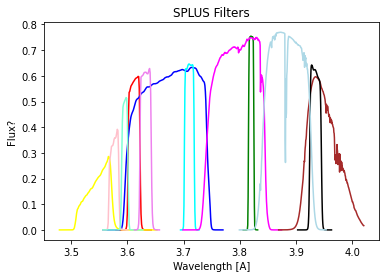

In [9]:
#graficando filtros
colors=['red','green','blue','cyan','magenta','brown','yellow','black','lightblue','pink','aquamarine','violet']
pedido=''
while pedido!='YES' and pedido!='NO':
    try:
        pedido=str(input('Requires legend? >')).upper()
  
    except(ValueError):
        print('Formato incorrecto')
    
for color,fil in zip(colors,Filtros):
    #print(color)
    xau=colors.index(color)
    plt.plot(np.log10(Tablas_general_filtros[xau]['col1']),Tablas_general_filtros[xau]['col2'],color)
    if pedido=='YES':
        plt.legend(Filtros)
    #print(xau)
    
    plt.title('SPLUS Filters')
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux?')
plt.show()


In [10]:
#Tabla continua/ Datos de filtros como una unica tabla
Tabla_continua=Table()
wave=[]
flux=[]
for table in Tablas_general_filtros:
    for value in table['col1']:
        wave.append(value)
    for value in table['col2']:
        flux.append(value)

Tabla_continua['Wavelength']=wave
Tabla_continua['Flux']=flux
#Tabla_continua #tabla de datos mixtos de todos los filtros

In [11]:
#normalizar filtros
Tabla_continua_normalizada=Table()
maxi=max(Tabla_continua['Flux'])
mini=min(Tabla_continua['Flux'])

LogW=[]
Nflux=[]

for value in Tabla_continua:
    auxiliar1=np.log10(value['Wavelength'])
    auxiliar2=(value['Flux']-mini)/(maxi-mini)
    LogW.append(auxiliar1)
    Nflux.append(auxiliar2)

Tabla_continua_normalizada['Log Wavelength']=LogW
Tabla_continua_normalizada['Normalized Flux']=Nflux

In [12]:
#Separación normalizado
Tablas_para_filtros=[Table() for i in range(len(Tablas_general_filtros))]
contador=0
c=0
for par,tabla in zip(Tablas_general_filtros,Tablas_para_filtros):
    #print(len(par))
    contador=len(par)+c
    auxiliar_alpha=[]
    auxiliar_beta=[]
    for datos in Tabla_continua_normalizada[c:contador]:
        auxiliar_alpha.append(datos[0])
        auxiliar_beta.append(datos[1])
        c+=1
  
    tabla['Log Wavelength']=auxiliar_alpha
    tabla['Normalized Flux']=auxiliar_beta

In [13]:
#parte 4: espectro

In [14]:
datos=os.listdir('SC2')
datos=sorted(datos[1:len(datos)])


search2=''
while search2 not in datos:
    print(f'The options are: ')
    for value in datos:
        print(f'{value}')
    search2=str(input('File name: >'))
    if search2 in datos:
        pass

aux0=sorted(os.listdir(f'SC2/{search2}'))
dts=[]
for value in aux0:
    if value=='.DS_Store':
        continue
    dts.append(value)


subdatos=dts

print(subdatos)
ind=[subdatos.index(i)+65 for i in subdatos]
ltr=[chr(number) for number in ind]
names=[f'{search2}{letra}' for letra in ltr]


search3=''
while search3 not in ltr:
    print('Options:')
    for value,lt in zip(names,ltr):
        print(f'for {value}, mark {lt}')
    try:
        search3=str(input('Which file would you want to open? >')).upper()
    except(ValueError):
        pass
    
ind2=ltr.index(search3)
topen=f'SC2/{search2}/{subdatos[ind2]}'

The options are: 
fig1
fig13
fig15
fig2
fig25
fig27
fig7
fig9
File name: >fig1
['fig1a.dat.txt', 'fig1b.dat.txt', 'fig1c.dat.txt', 'fig1d.dat.txt', 'fig1e.dat.txt']
Options:
for fig1A, mark A
for fig1B, mark B
for fig1C, mark C
for fig1D, mark D
for fig1E, mark E
Which file would you want to open? >a


In [15]:
alpha=[]
print(topen)
with open(topen,'r') as datos:
    line=datos.readlines()
    for linea in line:
        alpha.append(linea.split())
        
columns=(alpha[2][1:])
ages=columns[1:]

totaldatos=alpha[3:]
test001=colxfil(totaldatos)

wavelength=[(aux[0]) for aux in totaldatos]

por_longitud=[(aux[1:]) for aux in totaldatos] #usar este
por_edad=colxfil(por_longitud)

SC2/fig1/fig1a.dat.txt


In [59]:
FloatNorm_por_edad=[]
for i in por_edad:
    FloatNorm_por_edad.append(norm([10**float(l) for l in i]))
#[len(i) for i in FloatNorm_por_edad]
len(FloatNorm_por_edad)

36

In [60]:
#(ages)

In [270]:
#tabla sin cambios
Tabla_datos=Table()
Tabla_datos['WL']=[(float(w)) for w in wavelength]
NE=([(i) for i in FloatNorm_por_edad])
for edad,name in zip(NE,ages):
    Tabla_datos[f'{name}']=edad

In [271]:
Tabla_datos

WL,1Myr,2Myr,3Myr,4Myr,5Myr,6Myr,7Myr,8Myr,9Myr,10Myr,11Myr,12Myr,13Myr,14Myr,15Myr,16Myr,17Myr,18Myr,19Myr,20Myr,30Myr,40Myr,50Myr,60Myr,70Myr,80Myr,90Myr,100Myr,200Myr,300Myr,400Myr,500Myr,600Myr,700Myr,800Myr,900Myr
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
91.0,0.0,0.0,0.0,0.023859269109149858,0.016078936237300712,0.05281124013195215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94.0,1.4464052201245895e-18,4.5948401943460315e-22,1.9950948076818625e-26,0.028433207020103476,0.01862529859965421,0.06129687843947892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96.0,5.524650607582336e-18,2.015921945484253e-21,1.1582050116035713e-25,0.03218260103761122,0.020688403544141924,0.06816314303638517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98.0,1.0970508173249494e-17,4.376218801748522e-21,2.9929135705652377e-25,0.035910818971911354,0.022720087206132153,0.0749239411536891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100.0,2.316517714147422e-17,1.0327531803506048e-20,8.819375811455172e-25,0.03870240069182595,0.024128025632875336,0.07961249078188956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102.0,5.667469854079707e-17,2.9109846595609196e-20,3.2724086288369973e-24,0.04071829250206412,0.025072224873396137,0.08275830260056415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104.0,1.062355070554646e-16,6.067786723782825e-20,8.35376267866345e-24,0.04119551395010716,0.025159555897366622,0.08304463989946147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
106.0,1.9456467178930333e-16,1.2337576547008454e-19,2.067615778293894e-23,0.04158246372286091,0.02514739233782789,0.08297009703617962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108.0,3.861536622997368e-16,2.758652646095622e-19,5.783412755742905e-23,0.04191799157476422,0.02517868194956182,0.08303890345618214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
#Log y Normalizando el espectro
longitudes=[np.log10(float(val)) for val in wavelength]

por_longflout=[]

for lista in por_longitud:
    por_longflin=[]
    for value in lista:
        por_longflin.append((float(value)))
    por_longflout.append(por_longflin)

por_edadflout=[]

for lista in FloatNorm_por_edad:
    por_edadflin=[]
    for value in lista:
        por_edadflin.append((float(value)))

    por_edadflout.append(por_edadflin)
Norm_spectra=[norm(edad) for edad in por_edadflout]

In [64]:
Tabla_espectro_final=Table()

Tabla_espectro_final['Log WL']=longitudes
for names,Nedad in zip(columns[1:],Norm_spectra):
    Tabla_espectro_final[f'{names}']=Nedad
Tabla_espectro_final

Log WL,1Myr,2Myr,3Myr,4Myr,5Myr,6Myr,7Myr,8Myr,9Myr,10Myr,11Myr,12Myr,13Myr,14Myr,15Myr,16Myr,17Myr,18Myr,19Myr,20Myr,30Myr,40Myr,50Myr,60Myr,70Myr,80Myr,90Myr,100Myr,200Myr,300Myr,400Myr,500Myr,600Myr,700Myr,800Myr,900Myr
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1.9590413923210936,0.0,0.0,0.0,0.023859269109149858,0.016078936237300712,0.05281124013195215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.9731278535996986,1.4464052201245895e-18,4.5948401943460315e-22,1.9950948076818625e-26,0.028433207020103476,0.01862529859965421,0.06129687843947892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.9822712330395684,5.524650607582336e-18,2.015921945484253e-21,1.1582050116035713e-25,0.03218260103761122,0.020688403544141924,0.06816314303638517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.9912260756924949,1.0970508173249494e-17,4.376218801748522e-21,2.9929135705652377e-25,0.035910818971911354,0.022720087206132153,0.0749239411536891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,2.316517714147422e-17,1.0327531803506048e-20,8.819375811455172e-25,0.03870240069182595,0.024128025632875336,0.07961249078188956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0086001717619175,5.667469854079707e-17,2.9109846595609196e-20,3.2724086288369973e-24,0.04071829250206412,0.025072224873396137,0.08275830260056415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0170333392987803,1.062355070554646e-16,6.067786723782825e-20,8.35376267866345e-24,0.04119551395010716,0.025159555897366622,0.08304463989946147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0253058652647704,1.9456467178930333e-16,1.2337576547008454e-19,2.067615778293894e-23,0.04158246372286091,0.02514739233782789,0.08297009703617962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.03342375548695,3.861536622997368e-16,2.758652646095622e-19,5.783412755742905e-23,0.04191799157476422,0.02517868194956182,0.08303890345618214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


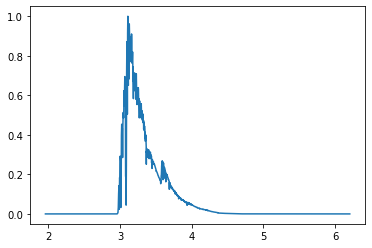

In [272]:
#normalizando los espectros
#for name in columns[1:]:
#    plt.plot(Tabla_espectro_final['Log WL'],Tabla_espectro_final[name])
plt.plot(Tabla_espectro_final['Log WL'],Tabla_espectro_final['50Myr'])
#for filt in Tablas_para_filtros:
#    plt.plot(filt['Log Wavelength'],filt['Normalized Flux'])

plt.show()

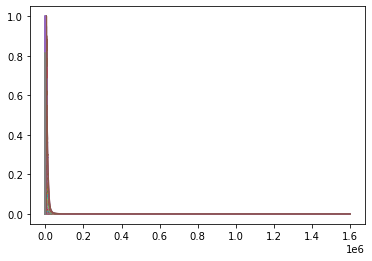

In [273]:
#normalizando los espectros
for name in columns[1:]:
    plt.plot(Tabla_datos['WL'],Tabla_datos[name])

for filt in Tablas_para_filtros:
    plt.plot(filt['Log Wavelength'],filt['Normalized Flux'])

plt.show()

In [278]:
Tablas_espectros_por_edad=[Table() for edad in range(len(columns[1:]))]
c=0

for table,name in zip(Tablas_espectros_por_edad,columns[1:]):
    if name!='[A]':
        table['WL']=Tabla_datos['WL']
        table[f'{name}']=Tabla_datos[name]

In [279]:
Tablas_espectros_por_edad

[<Table length=1221>
     WL             1Myr         
  float64         float64        
 --------- ----------------------
      91.0                    0.0
      94.0 1.4464052201245895e-18
      96.0  5.524650607582336e-18
      98.0 1.0970508173249494e-17
     100.0  2.316517714147422e-17
     102.0  5.667469854079707e-17
     104.0  1.062355070554646e-16
     106.0 1.9456467178930333e-16
     108.0  3.861536622997368e-16
     110.0   9.05229341463824e-16
     114.0  2.592273137327299e-15
     118.0  7.373404756845893e-15
     121.0 1.8514129726298675e-14
     125.0 4.3408310029285915e-14
     127.0  7.483863697844836e-14
     128.0 1.0125977242605892e-13
     131.0 1.5911021296566986e-13
     132.0 2.4267147288193837e-13
     134.0  3.311456591493208e-13
     137.0  5.693370634547257e-13
     140.0 1.0802884027683414e-12
     143.0  2.090835436591974e-12
     147.0  4.095905466089219e-12
     151.0  8.006449364862913e-12
     155.0 1.5839810459593388e-11
     159.0 2.75391155810942

In [26]:
#parte 5: espectros de Johnson

In [290]:
tabula=Table() #filtro V
TSP=Table()
alpha=[]
beta=[]
al=[]
bet=[]
with open('J_Filter/Bessel_V-1.txt') as dt:
    data=dt.readlines()
    data.reverse()
    for dat in data[1:len(data)-1]:
        #print(dat.split())
        al.append(10*float(dat.split()[0]))
        bet.append(dat.split()[1])
        alpha.append(10*float(dat.split()[0]))
        beta.append(float(dat.split()[1]))

TSP['[A]']=(alpha)
TSP['Tr']=[float(b) for b in bet]
tabula['[A]']=((alpha))
tabula['Tr']=(beta)
(tabula)

[A],Tr
float64,float64
2000.0,-0.000894984
2005.0,0.001555391
2010.0,0.001068685
2015.0,0.00088376
2020.0,0.001056454
2025.0,0.000744564
2030.0,0.001200153
2035.0,0.001362229
2040.0,0.0007975


In [70]:
tabulaB=Table() #filtro B
TSB=Table()
alpha=[]
beta=[]
al=[]
bet=[]
with open('J_Filter/Bessel_B-1.txt') as dt2:
    data=dt2.readlines()
    data.reverse()
    for dat in data[1:len(data)-1]:
        #print(dat.split())
        al.append(10*float(dat.split()[0]))
        bet.append(dat.split()[1])
        alpha.append(10*float(dat.split()[0]))
        beta.append(float(dat.split()[1]))

TSB['[A]']=np.log10(alpha)
TSB['Tr']=[float(b) for b in bet]
tabulaB['[A]']=(np.log10(alpha))
tabulaB['Tr']=norm(beta)
tabulaB

[A],Tr
float64,float64
3.3010299956639813,0.00013501054588655546
3.302114376956201,0.00013864078427571
3.303196057420489,0.00014104602232871142
3.3042750504771283,0.00012906587433187932
3.305351369446624,0.00013884742247710258
3.3064250275506875,0.00014825033255807778
3.307496037913213,0.00011662764967622579
3.3085644135612386,0.00014062437802596093
3.3096301674258988,0.00012650494566632966


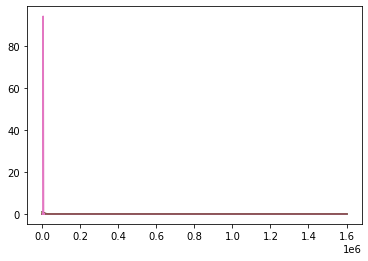

In [280]:
for tab,age in zip(Tablas_espectros_por_edad,columns[1:]):
    plt.plot(tab['WL'],tab[age])
plt.plot(tabula['[A]'],tabula['Tr'])
plt.show()

In [71]:
tabulaI=Table() #filtro I
TSI=Table()
alpha=[]
beta=[]
al=[]
bet=[]
with open('J_Filter/Bessel_I-1.txt') as dt3:
    data=dt3.readlines()
    data.reverse()
    for dat in data[1:len(data)-1]:
        #print(dat.split())
        al.append(10*float(dat.split()[0]))
        bet.append(dat.split()[1])
        alpha.append(10*float(dat.split()[0]))
        beta.append(float(dat.split()[1]))

TSI['[A]']=np.log10(alpha)
TSI['Tr']=[float(b) for b in bet]
tabulaI['[A]']=(np.log10(alpha))
tabulaI['Tr']=norm(beta)
tabulaI

[A],Tr
float64,float64
3.3010299956639813,3.646062519673641e-05
3.302114376956201,2.3882463193236875e-05
3.303196057420489,3.7836807320702065e-05
3.3042750504771283,3.75053128850043e-05
3.305351369446624,1.675494823730773e-05
3.3064250275506875,2.056405754041428e-05
3.307496037913213,2.0434316114778398e-05
3.3085644135612386,4.505522027111813e-05
3.3096301674258988,3.756800079864073e-05


In [72]:
tabulaR=Table() #filtro R
TSR=Table()
alpha=[]
beta=[]
al=[]
bet=[]
with open('J_Filter/Bessel_R-1.txt') as dt4:
    data=dt4.readlines()
    data.reverse()
    for dat in data[1:len(data)-1]:
        #print(dat.split())
        al.append(10*float(dat.split()[0]))
        bet.append(dat.split()[1])
        alpha.append(10*float(dat.split()[0]))
        beta.append(float(dat.split()[1]))

TSR['[A]']=np.log10(alpha)
TSR['Tr']=[float(b) for b in bet]
tabulaR['[A]']=(np.log10(alpha))
tabulaR['Tr']=norm(beta)
tabulaR

[A],Tr
float64,float64
3.302114376956201,0.00014309845793751734
3.303196057420489,0.00013678152084581292
3.3042750504771283,0.00014404072841886544
3.305351369446624,0.0001553711798825972
3.3064250275506875,0.00014784544852162207
3.307496037913213,0.00014299644807755759
3.3085644135612386,0.00016300832782545872
3.3096301674258988,0.0001443964513559527
3.3106933123433606,0.00012697024887290144


In [73]:
tabulaU=Table() #filtro U
TSU=Table()
alpha=[]
beta=[]
al=[]
bet=[]
with open('J_Filter/Bessel_U-1.txt') as dt4:
    data=dt4.readlines()
    data.reverse()
    for dat in data[1:len(data)-1]:
        #print(dat.split())
        al.append(10*float(dat.split()[0]))
        bet.append(dat.split()[1])
        alpha.append(10*float(dat.split()[0]))
        beta.append(float(dat.split()[1]))

TSU['[A]']=np.log10(alpha)
TSU['Tr']=[float(b) for b in bet]
tabulaU['[A]']=(np.log10(alpha))
tabulaU['Tr']=norm(beta)
tabulaU

[A],Tr
float64,float64
3.3010299956639813,0.00018071808832097324
3.302114376956201,0.0001733031029980094
3.303196057420489,0.00018577216867905673
3.3042750504771283,0.00020152112543637686
3.305351369446624,0.0002378663708377583
3.3064250275506875,0.00022655759923412703
3.307496037913213,0.0001907145040705903
3.3085644135612386,0.00020585505769671116
3.3096301674258988,0.0001893358844811757


In [310]:
convolu=[] #convolucion del filtro V, convolu guarda: edad, tabla de datos que se convolucionan, magnitud de convolucion
for Ename,Dedad in zip(ages,Tablas_espectros_por_edad):
    convolucion=convol(Dedad,tabula)
    print(f'Edad {Ename} : {convolucion[1]}')
    convolu.append([Ename,convolucion[0],convolucion[1]])
    

Edad 1Myr : 10.872156649723598
Edad 2Myr : 10.316433731689182


KeyboardInterrupt: 

In [294]:
for tri in convolu:
    #plt.plot(tri[1]['Wavelength'],tri[1]['Spectra'])
    print(-2.5*(np.log10(tri[2])-np.log10(4.0*(10**33))))
    #print(max(tri[1]['Spectra']))

#plt.show()

81.41436072524031
81.47132599631291
81.09865807166912
80.30860595245683
80.30675768940637
79.6180724028493
79.67786092309541
80.1507690033179
79.92492033524921
79.72904254769347
79.72709603070217
79.61621099700139
79.52452053634387
79.43388637769681
79.43656677236191
79.28996106580543
79.24071596848177
79.18138634984807
79.048157662978
78.99695019453326
78.5131896885481
78.22730145199513
77.95546920667311
77.76457184683088
77.55762419197133
77.40970740315437
77.27604656929938
77.16267126829872
76.43404214710512
76.3266876676537
76.20591377985727
76.10261124966888
76.0448400626216
75.99536311632487
75.9347150042923
75.91096529593126


In [302]:
test=test_convol(Tablas_espectros_por_edad[0],tabula)

In [329]:
test_parte_2=Table()
test_parte_2['WL']=test['Wavelength']
test_parte_2['Spectra']=test['Spectra']*test['Filter']
arriba=(auc(test_parte_2['WL'],test_parte_2['Spectra']))
abajo=auc(test['Wavelength'],test['Filter'])


23.738853456602342

In [326]:
10**((21.1-0.03)/2.5)

267916832.4819037

In [330]:
(0.03+2.5*np.log10(3.8*10**33))

83.97945899154202

In [303]:
test

Wavelength,Spectra,Filter
float64,object,object
2000.0,0.15920827578557478,-0.000894984
2005.0,0.15948138551654986,0.001555391
2010.0,0.15830404466147274,0.001068685
2015.0,0.15712670380639568,0.00088376
2020.0,0.15661103304098956,0.001056454
2025.0,0.1560953622755835,0.000744564
2030.0,0.15362126264204234,0.001200153
2035.0,0.15114716300850103,0.001362229
2040.0,0.15014630498961679,0.0007975


In [198]:
#graficar luminosidad

In [236]:
Tabla_luminnosidades_V=Table()
edadstr=[]
lum=[]
graficos=[]
for c in convolu:
    edadstr.append(c[0])
    lum.append(c[2])
    graficos.append(c[1])
edad=[]
for string in edadstr:
    #print(string)
    edad.append((10**6)*float((string.split('M'))[0]))
Tabla_luminnosidades_V['Ages']=(edad)
Tabla_luminnosidades_V['Luminosity']=lum
Tabla_luminnosidades_V

Ages,Luminosity
float64,float64
1000000.0,0.0011809622308546217
2000000.0,0.0011533281940467003
3000000.0,0.0014278983749753359
4000000.0,0.002406727929712307
5000000.0,0.0024136286521234773
6000000.0,0.003957817289342496
7000000.0,0.003761025866086205
8000000.0,0.0026376721768520306
9000000.0,0.0030941115429349046


In [223]:
graficos[0]

Wavelength,Spectra
float64,float64
3.3010299956639813,0.00011625281245443908
3.302114376956201,0.00014228181918019285
3.303196057420489,0.00013711180489769947
3.3042750504771283,0.00013514744676118568
3.305351369446624,0.00013698188160789172
3.3064250275506875,0.00013366884302902304
3.307496037913213,0.00013850831827064093
3.3085644135612386,0.00014022996385308574
3.3096301674258988,0.00013423115349172138


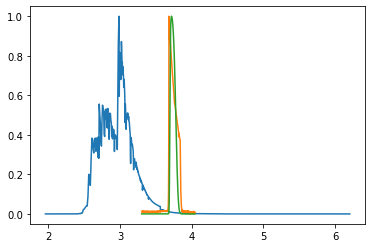

In [237]:
plt.plot(Tablas_espectros_por_edad[0]['Log WL'],norm(Tablas_espectros_por_edad[0]['1Myr']))
plt.plot(graficos[0]['Wavelength'],norm(graficos[0]['Spectra']))
plt.plot(tabula['[A]'],tabula['Tr'])
plt.show()

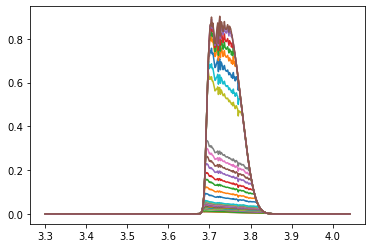

In [245]:
for table in convolu:
    plt.plot(table[1]['Wavelength'],table[1]['Spectra'])
plt.show()

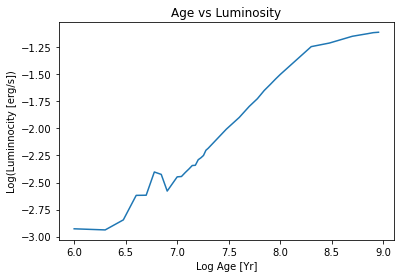

In [331]:
#plt.scatter(c[0],np.log10(c[2]))
plt.plot(np.log10((Tabla_luminnosidades_V['Ages'])),np.log10(Tabla_luminnosidades_V['Luminosity']))

#plt.ylim(-1.5,-3)
plt.title('Age vs Luminosity')
plt.xlabel('Log Age [Yr]')
plt.ylabel('Log(Luminnocity [erg/s])')
plt.show()

In [ ]:
convolu2=[] #convolucion del filtro B, convolu2 guarda: edad, tabla de datos que se convolucionan, magnitud de convolucion
for Ename,Dedad in zip(ages,Tablas_espectros_por_edad):
    convolucion=convol(Dedad,tabulaB)
    print(f'Edad {Ename} : {convolucion[1]}')
    convolu2.append([Ename,convolucion[0],convolucion[1]])([Ename,convolucion])

In [ ]:
convolu3=[] #convolucion del filtro I, convolu3 guarda: edad, tabla de datos que se convolucionan, magnitud de convolucion
for Ename,Dedad in zip(ages,Tablas_espectros_por_edad):
    convolucion=convol(Dedad,tabulaI)
    print(f'Edad {Ename} : {convolucion[1]}')
    convolu3.append([Ename,convolucion[0],convolucion[1]])

In [ ]:
convolu4=[] #convolucion del filtro R, convolu4 guarda: edad, tabla de datos que se convolucionan, magnitud de convolucion
for Ename,Dedad in zip(ages,Tablas_espectros_por_edad):
    convolucion=convol(Dedad,tabulaR)
    print(f'Edad {Ename} : {convolucion[1]}')
    convolu4.append([Ename,convolucion[0],convolucion[1]])

In [ ]:
convolu5=[] #convolucion del filtro U, convolu5 guarda: edad, tabla de datos que se convolucionan, magnitud de convolucion
for Ename,Dedad in zip(ages,Tablas_espectros_por_edad):
    convolucion=convol(Dedad,tabulaU)
    print(f'Edad {Ename} : {convolucion[1]}')
    convolu5.append([Ename,convolucion[0],convolucion[1]])

In [ ]:
for alpha in convolu5:
    plt.scatter(alpha[0],alpha[1])
plt.show()

In [ ]:
#zona de datos solares, NO USAR

In [125]:
archivo_sol=('Solar/AM0AM1_5.xls')
book = xlrd.open_workbook(archivo_sol)
for i, s in enumerate(book.sheets()):
    print(i, s.name, s.sheet_selected, s.sheet_visible)

0 Spectra 1 1


In [126]:
print("The number of worksheets is {0}".format(book.nsheets))
print("Worksheet name(s): {0}".format(book.sheet_names()))
sh = book.sheet_by_index(0)
print("{0} {1} {2}".format(sh.name, sh.nrows, sh.ncols))
print("Cell D30 is {0}".format(sh.cell_value(rowx=29, colx=3)))
for rx in range(sh.nrows):
    print(sh.row(rx))

The number of worksheets is 1
Worksheet name(s): ['Spectra']
Spectra 2004 7
Cell D30 is 4.7095e-07
[text:'ASTM G173-03 Reference Spectra Derived from SMARTS v. 2.9.2 (AM1.5)', empty:'', empty:'', empty:'', empty:'', text:'ASTM E-490 AM0 Standard Spectra', empty:'']
[text:'Wavelength (nm)', text:'Extraterrestrial W*m-2*nm-1', text:'Global tilt  W*m-2*nm-1', text:'Direct+circumsolar W*m-2*nm-1', empty:'', text:'Wavelength (nm)', text:'W*m-2*nm-1']
[number:280.0, number:0.082, number:4.7309e-23, number:2.5361e-26, empty:'', number:119.5, number:6.19e-05]
[number:280.5, number:0.099, number:1.2307e-21, number:1.0917e-24, empty:'', number:120.5, number:0.0005614]
[number:281.0, number:0.15, number:5.6895e-21, number:6.1253e-24, empty:'', number:121.5, number:0.004901]
[number:281.5, number:0.212, number:1.5662e-19, number:2.7479e-22, empty:'', number:122.5, number:0.001184]
[number:282.0, number:0.267, number:1.1946e-18, number:2.8346e-21, empty:'', number:123.5, number:4.77e-05]
[number:28

In [127]:
columnas=[5,6]
filas=[i for i in range(2,1699)]

wl_sun=[]
fl_sun=[]
for col in columnas:
    for fil in filas:
        if col==5:
            wl_sun.append(sh.cell_value(rowx=fil,colx=col)*10)
        if col==6:
            fl_sun.append(sh.cell_value(rowx=fil,colx=col)*(10**-3))
SUN=Table()
SUN['Wavelength']=np.log10(wl_sun)
SUN['Spectra']=norm(fl_sun)

In [128]:
SUN

Wavelength,Spectra
float64,float64
3.0773679052841563,2.88712670802694e-05
3.080987046910887,0.00026184701334929346
3.084576277934331,0.002285914177531589
3.0881360887005513,0.0005522388043945273
3.0916669575956846,2.2248132751900748e-05
3.095169351431755,1.5998132751890892e-05
3.098643725817057,1.3432834244424162e-05
3.1020905255118367,1.6417908871294542e-05
3.1055101847699738,9.934699916060438e-06


In [ ]:
#Fin Zona de datos solares

In [ ]:
Sun_lum=4*(10**33)    #testear auc(SUN['Wavelength'],SUN['Spectra'])
Sun_mag=4.83

for value in convolu:
    aux=value[1]/Sun_lum
    print(Sun_mag-2.5*np.log10(aux))
#print(Sun_lum)

In [133]:
'''for a,b in SUN:
    if b==max(SUN['Spectra']):
        print(a)
max(SUN['Spectra'])
L=auc(SUN['Wavelength'],SUN['Spectra'])
'''

3.6536947953150816


In [ ]:
#zona de calculo de magnitudes, en funcion de las luminosidades, #probar distintos Sum_lum

In [139]:
Sun_lum=4*(10**33) 
Sun_mag=4.83
V=[]
for value in convolu: 
    aux=value[2]/Sun_lum
    V.append(Sun_mag-2.5*np.log10(aux))
'''
B=[]
for value in convolu2:
    aux=value[1]/Sun_lum
    B.append(Sun_mag-2.5*np.log10(aux))
    
I=[]
for value in convolu3:
    aux=value[1]/Sun_lum
    I.append(Sun_mag-2.5*np.log10(aux))
    
R=[]
for value in convolu4:
    aux=value[1]/Sun_lum
    R.append(Sun_mag-2.5*np.log10(aux))
    
U=[]
for value in convolu5:
    aux=value[1]/Sun_lum
    U.append(Sun_mag-2.5*np.log10(aux))'''

'\nB=[]\nfor value in convolu2:\n    aux=value[1]/Sun_lum\n    B.append(Sun_mag-2.5*np.log10(aux))\n    \nI=[]\nfor value in convolu3:\n    aux=value[1]/Sun_lum\n    I.append(Sun_mag-2.5*np.log10(aux))\n    \nR=[]\nfor value in convolu4:\n    aux=value[1]/Sun_lum\n    R.append(Sun_mag-2.5*np.log10(aux))\n    \nU=[]\nfor value in convolu5:\n    aux=value[1]/Sun_lum\n    U.append(Sun_mag-2.5*np.log10(aux))'

In [140]:
V

[96.15455995738881,
 96.18026770621977,
 95.94840672995406,
 95.38158248352457,
 95.3784738465796,
 94.84151062495643,
 94.89688417769405,
 95.28209793265869,
 95.10881006334081,
 94.95399685284103,
 94.94576891177931,
 94.85165476682835,
 94.77217047721005,
 94.69199831837115,
 94.6866359221637,
 94.55801237917699,
 94.51307672654882,
 94.45935455730701,
 94.3395391039972,
 94.29293683512537,
 93.85158566255089,
 93.58150854982246,
 93.32658783935348,
 93.14831059239475,
 92.95670957573934,
 92.8195881872673,
 92.6942424051712,
 92.58807902996814,
 91.94403812171136,
 91.86140441467039,
 91.77389523354596,
 91.70547848141783,
 91.67311308588695,
 91.64634312915904,
 91.6212202138977,
 91.6116764020791]

In [ ]:
B_V=[] #intento de color
for v,b in zip(V,B):
    B_V.append(b-v)
I_R=[] #intento de color 2
for v,r in zip(I,R):
    I_R.append(v-r)

In [ ]:
plt.scatter(B_V,I_R)
 #plt.xlim(-0.1805,-0.1790)
plt.show()

In [242]:

2.5*np.log10(3.8*(10**33))

83.94945899154202